In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F

import torch
import os
import random

from itertools import islice

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight

from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from eeg_feature_extraction.eeg_utils import *
from neural_nets.models import *
from neural_nets.utils import *

%matplotlib inline

# set random seed for reproducibility
random.seed(42)

## Binary classification

### Normal Reading (NR) vs. Task Specific Reading (TSR)

In [2]:
classification = 'binary' # classification task
k = 30 # embeddings dimensionality

In [25]:
# load all word embeddings into memory
all_embeddings = load_embeddings(classification, k = k)

embeddings_nca_nr = all_embeddings[0]
embeddings_nca_tsr = all_embeddings[1]
embeddings_randomforest_nr = all_embeddings[2]
embeddings_randomforest_tsr = all_embeddings[3]

assert embeddings_randomforest_nr.shape == embeddings_nca_nr.shape
assert embeddings_randomforest_tsr.shape == embeddings_nca_tsr.shape

# get indices for held out test sentences
held_out_sents_nr = get_held_out_sents('task2')
held_out_sents_tsr = get_held_out_sents('task3')

# get number of sentences per task without held out test sentences
n_sents_nr = len(get_sent_lens_per_task('task2', held_out_sents_nr))
n_sents_tsr = len(get_sent_lens_per_task('task3', held_out_sents_tsr))

In [26]:
# reshape word embeddings into tensors of size N (number of sents) x T (sequence length per task) x D (embeddings dim)
embeddings_randomforest_nr_seq = reshape_into_tensor(embeddings_randomforest_nr, 'task2')
embeddings_randomforest_tsr_seq = reshape_into_tensor(embeddings_randomforest_tsr, 'task3')
embeddings_nca_nr_seq = reshape_into_tensor(embeddings_nca_nr, 'task2')
embeddings_nca_tsr_seq = reshape_into_tensor(embeddings_nca_tsr, 'task3')

assert embeddings_randomforest_nr_seq.shape == embeddings_nca_nr_seq.shape
assert embeddings_randomforest_tsr_seq.shape == embeddings_nca_tsr_seq.shape
assert embeddings_randomforest_nr_seq.shape[0] == embeddings_nca_nr_seq.shape[0] == n_sents_nr
assert embeddings_randomforest_tsr_seq.shape[0] == embeddings_nca_tsr_seq.shape[0] == n_sents_tsr

In [27]:
# vertically stack sequences on top of each other to create whole sequence data set
all_seq_randomforest = torch.cat((embeddings_randomforest_nr_seq , embeddings_randomforest_tsr_seq ), 0)
all_seq_nca = torch.cat((embeddings_nca_nr_seq , embeddings_nca_tsr_seq ), 0)

assert all_seq_randomforest.shape == all_seq_nca.shape

In [28]:
# create labels vector for binary classification task
labels_nr_bi, labels_tsr_bi = torch.zeros(n_sents_nr, dtype = torch.double), torch.ones(n_sents_tsr, dtype = torch.double)
all_labels_bi = torch.cat((labels_nr_bi, labels_tsr_bi), 0)

In [29]:
# split data set into 80% train, 10% val, 10% test
n_seq_total = n_sents_nr + n_sents_tsr
n_val_seq = n_seq_total // 10 * 2
n_train_seq = n_seq_total - n_val_seq

val_indices = list(set(random.sample(list(range(n_seq_total)), k = n_val_seq)))
train_indices = [i for i in range(n_seq_total) if i not in val_indices]

# split entire val set into dev and test
test_indices = val_indices[n_val_seq//2:]
val_indices = val_indices[:n_val_seq//2]

In [30]:
# create train and dev sets for binary and multiclass classification tasks
X_train_rf = all_seq_randomforest[train_indices]
X_train_nca = all_seq_nca[train_indices]

y_train_bi =  all_labels_bi[train_indices]

X_val_rf = all_seq_randomforest[val_indices]
X_val_nca = all_seq_nca[val_indices]

y_val_bi =  all_labels_bi[val_indices]

X_test_rf = all_seq_randomforest[test_indices]
X_test_nca = all_seq_nca[test_indices]

y_test_bi =  all_labels_bi[test_indices]

In [31]:
# define hyperparameters
seq_length = all_seq_nca.shape[1] # 20 if truncating, 65 if zero-padding
embedding_dim = k * 3
n_layers = 2
batch_size = 32
output_size = 1
hidden_dim = 50
lr = 0.01

epochs = 10

In [32]:
## Batches for binary classification ##

# create data loaders for both embeddings extracted via random forest and nca embeddings
train_loader_rf_bi, val_loader_rf_bi = get_data_batches(X_train_rf, y_train_bi, X_val_rf, y_val_bi, batch_size)
train_loader_nca_bi , val_loader_nca_bi = get_data_batches(X_train_nca, y_train_bi, X_val_nca, y_val_bi, batch_size)

In [33]:
## Test data loader for binary classification ##

test_loader_nca_bi, test_loader_rf_bi = get_data_batches(X_test_nca, y_test_bi, X_test_rf, y_test_bi, batch_size)

In [35]:
train_loader = train_loader_nca_bi
val_loader = val_loader_nca_bi
test_loader = test_loader_nca_bi

In [34]:
# instantiate the model with pre-defined hyperparameters
model = VanillaBiLSTM(embedding_dim, hidden_dim, output_size, n_layers, task = classification)

# we'll also set the model to the device that we defined earlier (default is CPU)
# model has to be converted to dtype double
model = model.double()
model.to(device)

# binary cross-entropy for binary classification task, cross-entropy loss for multiclass 
criterion = loss_func(classification)
optimizer = get_optim(model, lr)

In [36]:
train_losses, train_accs, train_f1_scores, val_losses, val_accs, val_f1_scores, model = fit(model, criterion, optimizer, train_loader, val_loader, classification, epochs, batch_size, seq_length)

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/10  Step: 10  Train Loss: 0.156  Train Acc: 0.834  Train F1: 0.789  Val Loss: 0.195  Val Acc: 0.969  Val F1: 0.969 


C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 2/10  Step: 20  Train Loss: 0.043  Train Acc: 1.000  Train F1: 1.000  Val Loss: 0.039  Val Acc: 1.000  Val F1: 1.000 
Validation loss decreased (inf --> 0.194921).  Saving model ...

Epoch: 2/10  Step: 30  Train Loss: 0.024  Train Acc: 0.998  Train F1: 0.998  Val Loss: 0.014  Val Acc: 1.000  Val F1: 1.000 
Validation loss decreased (0.194921 --> 0.194921).  Saving model ...

Epoch: 3/10  Step: 40  Train Loss: 0.020  Train Acc: 0.990  Train F1: 0.990  Val Loss: 0.074  Val Acc: 0.984  Val F1: 0.984 
Validation loss decreased (0.194921 --> 0.104234).  Saving model ...

Epoch: 3/10  Step: 50  Train Loss: 0.007  Train Acc: 0.996  Train F1: 0.996  Val Loss: 0.005  Val Acc: 1.000  Val F1: 1.000 
Validation loss decreased (0.104234 --> 0.104234).  Saving model ...

Epoch: 4/10  Step: 60  Train Loss: 0.011  Train Acc: 0.997  Train F1: 0.997  Val Loss: 0.004  Val Acc: 1.000  Val F1: 1.000 
Validation loss decreased (0.104234 --> 0.071190).  Saving model ...

Epoch: 5/10  Step: 70  Train L

In [37]:
print("Train accuracy: {}%".format(round(np.max(train_accs)*100, 3)))
print("Val accuracy: {}%".format(round(np.max(val_accs)*100, 3)))

Train accuracy: 100.0%
Val accuracy: 100.0%


In [38]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

Test loss: 0.001
Test accuracy: 100.000%
Test F1-score: 100.000%


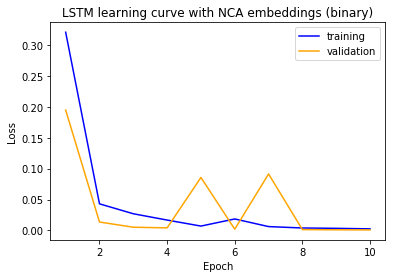

In [39]:
plt.plot(range(1,11), train_losses, color='blue')
plt.plot(range(1,11), val_losses, color='orange')
plt.title("LSTM learning curve with NCA embeddings (binary)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [62]:
# instantiate the model with pre-defined hyperparameters
model = VanillaBiLSTM(embedding_dim, hidden_dim, output_size, n_layers, task = classification)

# we'll also set the model to the device that we defined earlier (default is CPU)
# model has to be converted to dtype double
model = model.double()
model.to(device)

# binary cross-entropy for binary classification task, cross-entropy loss for multiclass 
criterion = loss_func(classification)
optimizer = get_optim(model, lr)

In [63]:
train_loader = train_loader_rf_bi
val_loader = val_loader_rf_bi
test_loader = test_loader_rf_bi

In [64]:
train_losses, train_accs, train_f1_scores, val_losses, val_accs, val_f1_scores, model = fit(model, criterion, optimizer, train_loader, val_loader, classification, epochs, batch_size, seq_length)

Epoch: 1/10  Step: 10  Train Loss: 0.760  Train Acc: 0.619  Train F1: 0.522  Val Loss: 0.731  Val Acc: 0.516  Val F1: 0.351 
Epoch: 2/10  Step: 20  Train Loss: 0.638  Train Acc: 0.615  Train F1: 0.478  Val Loss: 0.685  Val Acc: 0.516  Val F1: 0.352 
Validation loss decreased (inf --> 0.731481).  Saving model ...

Epoch: 2/10  Step: 30  Train Loss: 0.516  Train Acc: 0.702  Train F1: 0.635  Val Loss: 0.939  Val Acc: 0.531  Val F1: 0.385 
Validation loss decreased (0.731481 --> 0.731481).  Saving model ...

Epoch: 3/10  Step: 40  Train Loss: 0.612  Train Acc: 0.552  Train F1: 0.398  Val Loss: 0.686  Val Acc: 0.516  Val F1: 0.354 
Epoch: 3/10  Step: 50  Train Loss: 0.671  Train Acc: 0.629  Train F1: 0.546  Val Loss: 0.557  Val Acc: 0.781  Val F1: 0.774 
Epoch: 4/10  Step: 60  Train Loss: 0.502  Train Acc: 0.760  Train F1: 0.739  Val Loss: 0.503  Val Acc: 0.781  Val F1: 0.772 
Epoch: 5/10  Step: 70  Train Loss: 0.497  Train Acc: 0.828  Train F1: 0.825  Val Loss: 0.476  Val Acc: 0.750  Val F

In [65]:
print("Train accuracy: {}%".format(round(np.max(train_accs)*100, 3)))
print("Val accuracy: {}%".format(round(np.max(val_accs)*100, 3)))

Train accuracy: 96.289%
Val accuracy: 93.75%


In [66]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

Test loss: 0.355
Test accuracy: 85.938%
Test F1-score: 85.310%


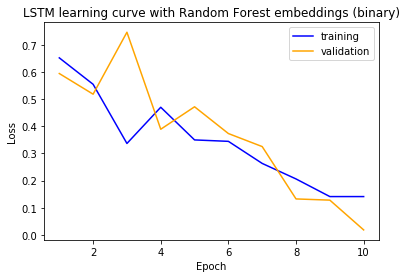

In [61]:
plt.plot(range(1,11), train_losses, color='blue')
plt.plot(range(1,11), val_losses, color='orange')
plt.title("LSTM learning curve with Random Forest embeddings (binary)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

### Task 1 First Half vs. Task 1 Second Half (Investigate whether order effect exists)

In [72]:
classification = 'binary' # classification task
k = 5 # embeddings dimensionality

In [73]:
# load all word embeddings into memory
all_embeddings = load_embeddings(classification, k = k, task='//task_1//')

embeddings_nca_task1_1, embeddings_nca_task1_2, embeddings_rf_task_1_1, embeddings_rf_task_1_2  = all_embeddings

assert embeddings_rf_task_1_1.shape == embeddings_nca_task1_1.shape
assert embeddings_rf_task_1_2.shape == embeddings_nca_task1_2.shape

# get number of sentences per task without held out test sentences
n_sents_task_1 = len(get_sent_lens_per_task('task1', list()))

In [74]:
embeddings_nca_task1 = np.vstack((embeddings_nca_task1_1, embeddings_nca_task1_2))
embeddings_rf_task1 = np.vstack((embeddings_rf_task_1_1, embeddings_rf_task_1_2))

In [75]:
# reshape word embeddings into tensors of size N (number of sents) x T (sequence length per task) x D (embeddings dim)
embeddings_rf_task1_seq = reshape_into_tensor(embeddings_rf_task1, 'task1')
embeddings_nc_task1_seq = reshape_into_tensor(embeddings_nca_task1, 'task1')

In [76]:
# vertically stack sequences on top of each other to create whole sequence data set
all_seq_rf = embeddings_rf_task1_seq
all_seq_nca = embeddings_nc_task1_seq

In [77]:
# create labels vector for binary classification task
labels_task_1_1, labels_task_1_2 = torch.zeros(n_sents_task_1 // 2, dtype = torch.double), torch.ones(n_sents_task_1 // 2, dtype = torch.double)
all_labels_task1 = torch.cat((labels_task_1_1, labels_task_1_2), 0)

In [78]:
# split data set into 60% train, 20% val, 20% test
n_seq_total = n_sents_task_1
n_val_seq = n_seq_total // 5 * 2
n_train_seq = n_seq_total - n_val_seq

val_indices = np.array(list(set(random.sample(list(range(n_seq_total)), k = n_val_seq))))
train_indices = [i for i in range(n_seq_total) if i not in val_indices]

# split entire val set into dev and test
test_indices = [idx for idx in islice(val_indices, 0, None, 2)] #list(filter(lambda idx: idx%2==0, val_indices))
val_indices = [idx for idx in islice(val_indices, 1, None, 2)] #list(filter(lambda idx: idx%2!=0, val_indices))

In [79]:
# create train and dev sets for binary classification tasks
X_train_rf = all_seq_rf[train_indices]
X_train_nca = all_seq_nca[train_indices]

y_train_bi =  all_labels_task1[train_indices]

X_val_rf = all_seq_rf[val_indices]
X_val_nca = all_seq_nca[val_indices]

y_val_bi =  all_labels_task1[val_indices]

X_test_rf = all_seq_rf[test_indices]
X_test_nca = all_seq_nca[test_indices]

y_test_bi =  all_labels_task1[test_indices]

In [80]:
# define hyperparameters
seq_length = all_seq_nca.shape[1] # 18 if truncating, 65 if zero-padding
embedding_dim = k * 3
n_layers = 2
batch_size = 16
output_size = 1
hidden_dim = 50
lr = 0.01

epochs = 10

In [81]:
## Batches for binary classification ##

# create data loaders for both embeddings extracted via random forest and nca embeddings
train_loader_rf_bi, val_loader_rf_bi = get_data_batches(X_train_rf, y_train_bi, X_val_rf, y_val_bi, batch_size)
train_loader_nca_bi , val_loader_nca_bi = get_data_batches(X_train_nca, y_train_bi, X_val_nca, y_val_bi, batch_size)

In [82]:
## Test data loader for binary classification ##

test_loader_nca_bi, test_loader_rf_bi = get_data_batches(X_test_nca, y_test_bi, X_test_rf, y_test_bi, batch_size)

In [83]:
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")

In [84]:
train_loader = train_loader_nca_bi
val_loader = val_loader_nca_bi
test_loader = test_loader_nca_bi

In [85]:
# instantiate the model with pre-defined hyperparameters
model = VanillaBiLSTM(embedding_dim, hidden_dim, output_size, n_layers, task = classification)

# we'll also set the model to the device that we defined earlier (default is CPU)
# model has to be converted to dtype double
model = model.double()
model.to(device)

# binary cross-entropy for binary classification task, cross-entropy loss for multiclass 
criterion = loss_func(classification)
optimizer = get_optim(model, lr)

In [43]:
train_losses, train_accs, train_f1_scores, val_losses, val_accs, val_f1_scores, model = fit(model, criterion, optimizer, train_loader, val_loader, classification, epochs, batch_size, seq_length)

C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/10  Step: 10  Train Loss: 0.188  Train Acc: 0.856  Train F1: 0.816  Val Loss: 0.162  Val Acc: 0.975  Val F1: 0.975 


C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 2/10  Step: 20  Train Loss: 0.026  Train Acc: 0.988  Train F1: 0.987  Val Loss: 0.082  Val Acc: 0.975  Val F1: 0.975 
Validation loss decreased (inf --> 0.162323).  Saving model ...

Epoch: 2/10  Step: 30  Train Loss: 0.017  Train Acc: 0.992  Train F1: 0.992  Val Loss: 0.067  Val Acc: 0.988  Val F1: 0.987 
Validation loss decreased (0.162323 --> 0.162323).  Saving model ...

Epoch: 3/10  Step: 40  Train Loss: 0.008  Train Acc: 1.000  Train F1: 1.000  Val Loss: 0.048  Val Acc: 0.988  Val F1: 0.987 
Validation loss decreased (0.162323 --> 0.114843).  Saving model ...

Epoch: 4/10  Step: 50  Train Loss: 0.003  Train Acc: 1.000  Train F1: 1.000  Val Loss: 0.034  Val Acc: 0.988  Val F1: 0.987 
Validation loss decreased (0.114843 --> 0.092555).  Saving model ...

Epoch: 4/10  Step: 60  Train Loss: 0.011  Train Acc: 1.000  Train F1: 1.000  Val Loss: 0.005  Val Acc: 1.000  Val F1: 1.000 
Validation loss decreased (0.092555 --> 0.092555).  Saving model ...

Epoch: 5/10  Step: 70  Train L

In [44]:
print("Train accuracy: {}%".format(round(np.mean(train_accs)*100, 3)))
print("Val accuracy: {}%".format(round(np.mean(val_accs)*100, 3)))

Train accuracy: 98.958%
Val accuracy: 99.5%


In [45]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

Test loss: 0.092
Test accuracy: 98.750%
Test F1-score: 98.755%


In [46]:
y_hat = np.array([val.item() for pred in preds for val in pred])
y_true = np.array([val for label in true_labels for val in label])
print(classification_report(y_true, y_hat, labels = np.unique(y_true), target_names = ['Task_1_Half1', 'Task_1_Half2']))

              precision    recall  f1-score   support

Task_1_Half1       1.00      0.97      0.99        40
Task_1_Half2       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



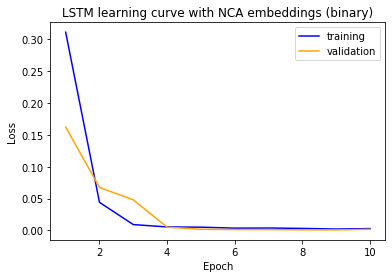

In [47]:
plt.plot(range(1, 11), train_losses, color='blue')
plt.plot(range(1, 11), val_losses, color='orange')
plt.title("LSTM learning curve with NCA embeddings (binary)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [86]:
# instantiate the model with pre-defined hyperparameters
model = VanillaBiLSTM(embedding_dim, hidden_dim, output_size, n_layers, task = classification)

# we'll also set the model to the device that we defined earlier (default is CPU)
# model has to be converted to dtype double
model = model.double()
model.to(device)

# binary cross-entropy for binary classification task, cross-entropy loss for multiclass 
criterion = loss_func(classification)
optimizer = get_optim(model, lr)

In [87]:
train_loader = train_loader_rf_bi
val_loader = val_loader_rf_bi
test_loader = test_loader_rf_bi

In [88]:
train_losses, train_accs, train_f1_scores, val_losses, val_accs, val_f1_scores, model = fit(model, criterion, optimizer, train_loader, val_loader, classification, epochs, batch_size, seq_length)

C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/10  Step: 10  Train Loss: 0.729  Train Acc: 0.494  Train F1: 0.420  Val Loss: 0.711  Val Acc: 0.438  Val F1: 0.280 


C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 2/10  Step: 20  Train Loss: 0.702  Train Acc: 0.562  Train F1: 0.468  Val Loss: 0.711  Val Acc: 0.438  Val F1: 0.280 
Validation loss decreased (inf --> 0.711247).  Saving model ...

Epoch: 2/10  Step: 30  Train Loss: 0.702  Train Acc: 0.529  Train F1: 0.413  Val Loss: 0.697  Val Acc: 0.438  Val F1: 0.292 
Validation loss decreased (0.711247 --> 0.711247).  Saving model ...

Epoch: 3/10  Step: 40  Train Loss: 0.732  Train Acc: 0.494  Train F1: 0.415  Val Loss: 0.701  Val Acc: 0.438  Val F1: 0.270 
Validation loss decreased (0.711247 --> 0.704348).  Saving model ...

Epoch: 4/10  Step: 50  Train Loss: 0.687  Train Acc: 0.625  Train F1: 0.581  Val Loss: 0.692  Val Acc: 0.438  Val F1: 0.279 
Validation loss decreased (0.704348 --> 0.703381).  Saving model ...

Epoch: 4/10  Step: 60  Train Loss: 0.690  Train Acc: 0.587  Train F1: 0.502  Val Loss: 0.684  Val Acc: 0.712  Val F1: 0.709 
Validation loss decreased (0.703381 --> 0.703381).  Saving model ...

Epoch: 5/10  Step: 70  Train L

In [89]:
print("Train accuracy: {}%".format(round(np.mean(train_accs)*100, 3)))
print("Val accuracy: {}%".format(round(np.mean(val_accs)*100, 3)))

Train accuracy: 54.5%
Val accuracy: 48.375%


In [90]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

Test loss: 0.721
Test accuracy: 45.000%
Test F1-score: 28.593%


In [91]:
y_hat = np.array([val.item() for pred in preds for val in pred])
y_true = np.array([val for label in true_labels for val in label])
print(classification_report(y_true, y_hat, labels = np.unique(y_true), target_names = ['Task_1_Half1', 'Task_1_Half2']))

C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

Task_1_Half1       0.45      1.00      0.62        36
Task_1_Half2       0.00      0.00      0.00        44

    accuracy                           0.45        80
   macro avg       0.23      0.50      0.31        80
weighted avg       0.20      0.45      0.28        80



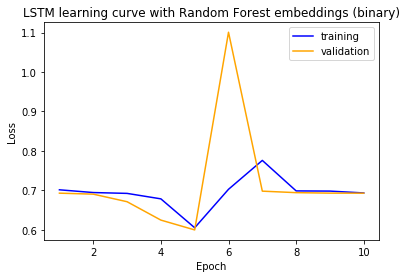

In [54]:
plt.plot(range(1,11), train_losses, color='blue')
plt.plot(range(1,11), val_losses, color='orange')
plt.title("LSTM learning curve with Random Forest embeddings (binary)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

## Multiclass classification

In [2]:
k = 30 # embedding dimensionality
classification = 'multiclass' # classification task
classes = ['NR_No_Rel','NR_Rel', 'TSR_No_Rel', 'TSR_Rel'] # class labels

In [3]:
indices_relations_task2, indices_no_relations_task2, indices_relations_task3, indices_no_relations_task3 = get_rel_labels()

In [4]:
# load all word embeddings into memory
all_embeddings = load_embeddings(classification, k=k)

embeddings_nca_nr = all_embeddings[0]
embeddings_nca_tsr = all_embeddings[1]

# get indices for held out test sentences
held_out_sents_nr = get_held_out_sents('task2')
held_out_sents_tsr = get_held_out_sents('task3')

# get number of sentences per task without held out test sentences
n_sents_nr = len(get_sent_lens_per_task('task2', held_out_sents_nr))
n_sents_tsr = len(get_sent_lens_per_task('task3', held_out_sents_tsr))

# get indices for (dev) sentences with and without relations respectively
indices_rel_nr = [idx for idx in indices_relations_task2 if idx not in held_out_sents_nr]
indices_no_rel_nr = [idx for idx in indices_no_relations_task2 if idx not in held_out_sents_nr]
indices_rel_tsr = [idx for idx in indices_relations_task3 if idx not in held_out_sents_tsr]
indices_no_rel_tsr = [idx for idx in indices_no_relations_task3 if idx not in held_out_sents_tsr]

In [5]:
# reshape word embeddings into tensors of size N (number of sents) x T (sequence length per task) x D (embeddings dim)
embeddings_nca_nr_seq = reshape_into_tensor(embeddings_nca_nr, 'task2', 'truncating')
embeddings_nca_tsr_seq = reshape_into_tensor(embeddings_nca_tsr, 'task3', 'truncating')

assert embeddings_nca_nr_seq.shape[0] == n_sents_nr
assert embeddings_nca_tsr_seq.shape[0] == n_sents_tsr

In [6]:
# vertically stack sequences on top of each other to create whole sequence data set
all_seq_nca = torch.cat((embeddings_nca_nr_seq , embeddings_nca_tsr_seq ), 0)

In [7]:
# create labels vector for multiclass-classification task
labels_nr_multi = create_multiclass_labels(indices_rel_nr, indices_no_rel_nr, n_sents_nr, 'task2')
labels_tsr_multi = create_multiclass_labels(indices_rel_tsr, indices_no_rel_tsr, n_sents_tsr, 'task3')
all_labels_multi = torch.cat((labels_nr_multi, labels_tsr_multi), 0)

In [8]:
# split data set into 70% train, 15% val, 15% test
n_seq_total = n_sents_nr + n_sents_tsr
n_val_seq = n_seq_total // 10 * 3
n_train_seq = n_seq_total - n_val_seq

val_indices = list(set(random.sample(list(range(n_seq_total)), k = n_val_seq)))
train_indices = [i for i in range(n_seq_total) if i not in val_indices]

# split entire val set into dev and test
test_indices = val_indices[n_val_seq//2:]
val_indices = val_indices[:n_val_seq//2]

In [9]:
# create train and dev sets for binary and multiclass classification tasks
X_train_nca = all_seq_nca[train_indices]
y_train_multi = all_labels_multi[train_indices]

X_val_nca = all_seq_nca[val_indices]
y_val_multi = all_labels_multi[val_indices]

X_test_nca = all_seq_nca[test_indices]
y_test_multi = all_labels_multi[test_indices]

In [21]:
# define hyperparameters
seq_length = all_seq_nca.shape[1] # 20 if truncating, 65 if zero-padding
print("Sequence length: {}".format(seq_length))

embedding_dim = k*3 # 3 = number of frequency domains (i.e., theta, alpha, beta)
n_layers = 3
batch_size = 16
output_size = 4
hidden_dim = 200
lr = 0.001

epochs = 30
print_every = 10
clip = 0.5
mask_index = -100 # -100 == default setting
valid_loss_min = np.Inf

Sequence length: 20


In [15]:
## Batches for multiclass classification ##

train_loader_nca_multi, val_loader_nca_multi = get_data_batches(X_train_nca, y_train_multi, X_val_nca, y_val_multi, batch_size)
test_loader_nca_multi, _= get_data_batches(X_test_nca, y_test_multi, X_val_nca, y_val_multi, batch_size)

In [22]:
# instantiate the model with pre-defined hyperparameters
model = VanillaBiLSTM(embedding_dim, hidden_dim, output_size, n_layers, task=classification)

# we'll also set the model to the device that we defined earlier (default is CPU)
# model has to be converted to dtype double
model = model.double()
model.to(device)

# compute class weights for multiclass classification problem
weights = torch.from_numpy(class_weight.compute_class_weight('balanced', np.unique(y_train_multi), y_train_multi.numpy()))

# binary cross-entropy for binary classification task, cross-entropy loss for multiclass 
criterion = loss_func(classification, weight=weights, mask_index=mask_index)
optimizer = get_optim(model, lr)

In [23]:
train_loader = train_loader_nca_multi
val_loader = val_loader_nca_multi
test_loader = test_loader_nca_multi

In [24]:
train_losses, train_accs, train_f1_scores, val_losses, val_accs, val_f1_scores, model = fit(model, 
                                                                                            criterion, 
                                                                                            optimizer,
                                                                                            train_loader, 
                                                                                            val_loader, 
                                                                                            classification, 
                                                                                            epochs, 
                                                                                            batch_size, 
                                                                                            seq_length, 
                                                                                            clip=clip)

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/30  Step: 10  Train Loss: 1.206  Train Acc: 0.356  Train F1: 0.311  Val Loss: 1.138  Val Acc: 0.594  Val F1: 0.532 


C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 1/30  Step: 20  Train Loss: 0.847  Train Acc: 0.425  Train F1: 0.371  Val Loss: 0.858  Val Acc: 0.385  Val F1: 0.256 


C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 2/30  Step: 30  Train Loss: 0.798  Train Acc: 0.500  Train F1: 0.400  Val Loss: 0.836  Val Acc: 0.573  Val F1: 0.496 
Validation loss decreased (inf --> 0.857683).  Saving model ...

Epoch: 2/30  Step: 40  Train Loss: 0.700  Train Acc: 0.540  Train F1: 0.504  Val Loss: 0.726  Val Acc: 0.583  Val F1: 0.487 
Validation loss decreased (0.857683 --> 0.857683).  Saving model ...

Epoch: 2/30  Step: 50  Train Loss: 0.636  Train Acc: 0.565  Train F1: 0.520  Val Loss: 0.705  Val Acc: 0.615  Val F1: 0.545 
Validation loss decreased (0.857683 --> 0.857683).  Saving model ...

Epoch: 3/30  Step: 60  Train Loss: 0.733  Train Acc: 0.531  Train F1: 0.493  Val Loss: 0.724  Val Acc: 0.479  Val F1: 0.431 
Validation loss decreased (0.857683 --> 0.781486).  Saving model ...

Epoch: 3/30  Step: 70  Train Loss: 0.671  Train Acc: 0.411  Train F1: 0.402  Val Loss: 0.708  Val Acc: 0.438  Val F1: 0.359 
Validation loss decreased (0.781486 --> 0.781486).  Saving model ...

Epoch: 3/30  Step: 80  Train L

In [15]:
print("Train accuracy: {}%".format(round(np.max(train_accs)*100, 3)))
print("Val accuracy: {}%".format(round(np.max(val_accs)*100, 3)))

Train accuracy: 57.366%
Val accuracy: 66.667%


In [132]:
print("Train accuracy: {}%".format(round(np.max(train_accs)*100, 3)))
print("Val accuracy: {}%".format(round(np.max(val_accs)*100, 3)))

Train accuracy: 65.179%
Val accuracy: 65.625%


In [16]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

Test loss: 0.683
Test accuracy: 66.667%
Test F1-score: 62.176%


In [120]:
test_acc, test_f1, test_loss, preds, true_labels = predict(model, criterion, test_loader, classification, batch_size)

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test loss: 0.714
Test accuracy: 62.500%
Test F1-score: 64.047%


In [17]:
y_hat = np.array([val for pred in preds for val in pred])
y_true = np.array([val for label in true_labels for val in label])
print(classification_report(y_true, y_hat, labels = np.unique(y_true), target_names = classes))

In [18]:
print(classification_report(y_true, y_hat, labels = np.unique(y_true), target_names = classes))

C:\Users\Lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

   NR_No_Rel       0.67      0.33      0.44        24
      NR_Rel       0.27      0.60      0.37        10
  TSR_No_Rel       0.00      0.00      0.00        12
     TSR_Rel       0.81      1.00      0.89        50

    accuracy                           0.67        96
   macro avg       0.44      0.48      0.43        96
weighted avg       0.62      0.67      0.62        96



In [146]:
print(classification_report(y_true, y_hat, labels = np.unique(y_true), target_names = classes))

              precision    recall  f1-score   support

   NR_No_Rel       0.83      0.50      0.62        20
      NR_Rel       0.50      0.83      0.62        12
  TSR_No_Rel       0.23      0.36      0.28        14
     TSR_Rel       0.79      0.66      0.72        50

    accuracy                           0.60        96
   macro avg       0.59      0.59      0.56        96
weighted avg       0.68      0.60      0.62        96



In [135]:
print(classification_report(y_true, y_hat, labels = np.unique(y_true), target_names = classes))

              precision    recall  f1-score   support

   NR_No_Rel       0.63      0.60      0.62        20
      NR_Rel       0.38      0.42      0.40        12
  TSR_No_Rel       0.23      0.21      0.22        14
     TSR_Rel       0.78      0.80      0.79        50

    accuracy                           0.62        96
   macro avg       0.51      0.51      0.51        96
weighted avg       0.62      0.62      0.62        96



Higher dimensional embeddings: 90-dimensional word vector
Normalized confusion matrix


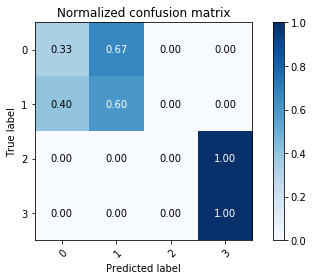

In [21]:
print("Higher dimensional embeddings: 90-dimensional word vector")
plot_confusion_matrix(y_true, y_hat, classes = np.unique(y_true), normalize = True)

Normalized confusion matrix


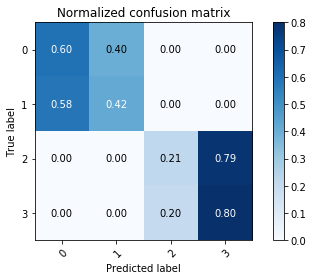

In [136]:
plot_confusion_matrix(y_true, y_hat, classes = np.unique(y_true), normalize = True)

Normalized confusion matrix


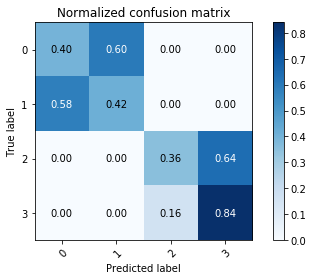

In [123]:
plot_confusion_matrix(y_true, y_hat, classes = np.unique(y_true), normalize = True)

Normalized confusion matrix


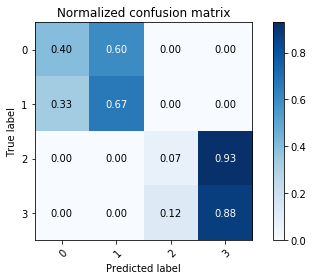

In [114]:
plot_confusion_matrix(y_true, y_hat, classes = np.unique(y_true), normalize = True)

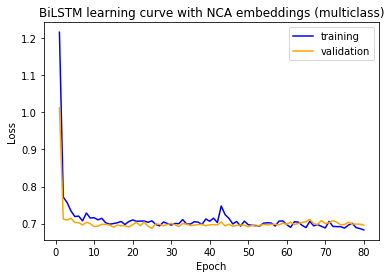

In [149]:
plt.plot(range(1,81), train_losses, color='blue')
plt.plot(range(1,81), val_losses, color='orange')
plt.title("BiLSTM learning curve with NCA embeddings (multiclass)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

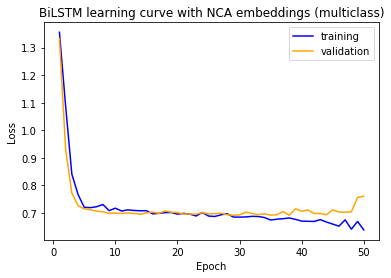

In [115]:
plt.plot(range(1,51), train_losses, color='blue')
plt.plot(range(1,51), val_losses, color='orange')
plt.title("BiLSTM learning curve with NCA embeddings (multiclass)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

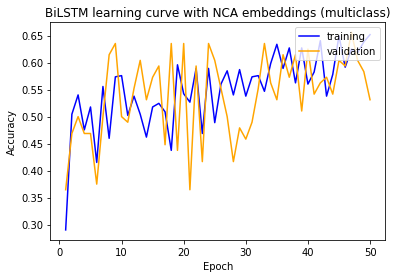

In [139]:
plt.plot(range(1,51), train_accs, color='blue')
plt.plot(range(1,51), val_accs, color='orange')
plt.title("BiLSTM learning curve with NCA embeddings (multiclass)")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')